# Wasserstein GAN
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.0.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j2"] # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 512 # Uses about 3 GB of VRAM
EPOCHS = 1000
LEARNING_RATE = 0.00005
N_CRITIC = 5

In [5]:
df = load_data("herwig", 10000)

# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
X_train, X_test = train_test_split(df[train_features], test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 12 batches of 512 samples each, total 6144 samples
Testset consists of 4 batches of 512 samples each, total 2048 samples


0

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features)))
    assert model.output_shape == (None, len(train_features))

    return model

In [9]:
generator = make_generator_model()

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [11]:
discriminator = make_discriminator_model()

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [14]:
def discriminator_loss(real_output, fake_output):
    return tf.math.subtract(fake_output, real_output)

In [15]:
def generator_loss(fake_output):
    return tf.math.negative(fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE, clipnorm = 1.0)

In [17]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [18]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [19]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [20]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [21]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    disc_loss = discriminator_loss(real_output, fake_output)

    return disc_loss

In [22]:
def graph_gan(generator):
    fakedata = np.array(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_2}$")
    plt.hist(np.array(X_train)[:,0], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [23]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [24]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [25]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [26]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(tf.math.reduce_mean(train_step_generator(image_batch)))
      for n in range(n_critic):
        train_disc_loss += K_eval(tf.math.reduce_mean(train_step_discriminator(image_batch)))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(tf.math.reduce_mean(evaluate_generator()))
      test_disc_loss += K_eval(tf.math.reduce_mean(evaluate_discriminator(test_batch)))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:tensorflow:Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

  1%|          | 11/1000 [00:03<03:15,  5.07it/s]
Epoch 10:

Generator training loss: -0.07790873510142167
Discriminator training loss: -0.6077425062656403

Generator validation loss: -0.09388862922787666
Discriminator validation loss: -0.6383447349

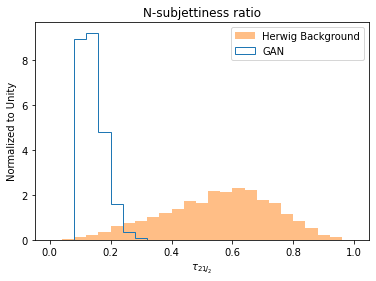

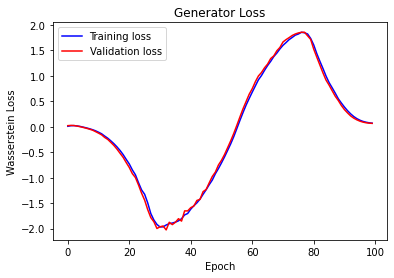

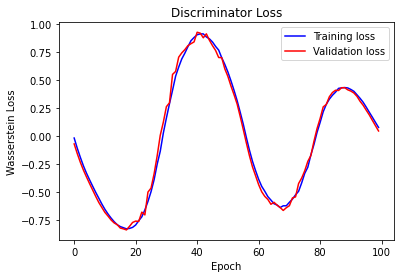

 11%|█         | 111/1000 [00:19<02:30,  5.89it/s]
Epoch 110:

Generator training loss: -0.11547596380114555
Discriminator training loss: -0.18771019503474234

Generator validation loss: -0.14412835985422134
Discriminator validation loss: -0.1749652661383152
 12%|█▏        | 121/1000 [00:21<02:14,  6.56it/s]
Epoch 120:

Generator training loss: -0.6261781603097916
Discriminator training loss: 0.13852613642811776

Generator validation loss: -0.6125337332487106
Discriminator validation loss: 0.1871468387544155
 13%|█▎        | 131/1000 [00:22<02:11,  6.62it/s]
Epoch 130:

Generator training loss: -0.019658413618647803
Discriminator training loss: 0.022206543847763292

Generator validation loss: 0.019187789410352707
Discriminator validation loss: 0.0017491427424829453
 14%|█▍        | 141/1000 [00:24<02:11,  6.51it/s]
Epoch 140:

Generator training loss: 0.5500269879897436
Discriminator training loss: -0.03667965216833788

Generator validation loss: 0.5443598181009293
Discriminator valida

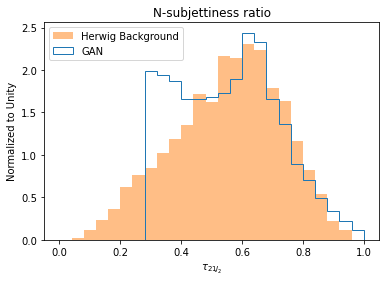

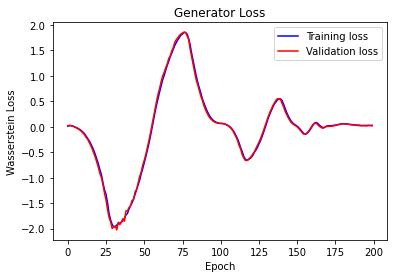

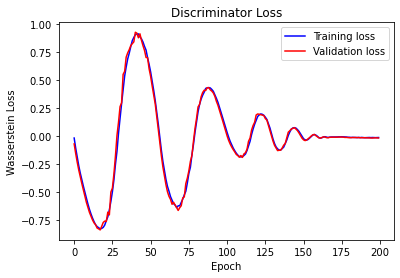

 21%|██        | 211/1000 [00:35<02:06,  6.25it/s]
Epoch 210:

Generator training loss: 0.013908085762523115
Discriminator training loss: -0.014973662789755812

Generator validation loss: 0.003739862295333296
Discriminator validation loss: -0.018031501211225986
 22%|██▏       | 221/1000 [00:37<02:08,  6.05it/s]
Epoch 220:

Generator training loss: 0.006724922471524526
Discriminator training loss: -0.010679125163005666

Generator validation loss: -0.008939577382989228
Discriminator validation loss: -0.010781534598208964
 23%|██▎       | 231/1000 [00:39<02:06,  6.10it/s]
Epoch 230:

Generator training loss: -0.007618597145968427
Discriminator training loss: -0.008901416689817173

Generator validation loss: -0.03672432620078325
Discriminator validation loss: -0.009134574793279171
 24%|██▍       | 241/1000 [00:40<02:06,  5.99it/s]
Epoch 240:

Generator training loss: -0.029210624595483143
Discriminator training loss: -0.006059635075507686

Generator validation loss: -0.050161903724074364
D

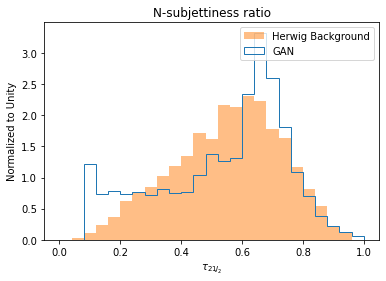

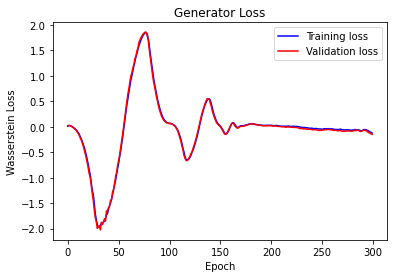

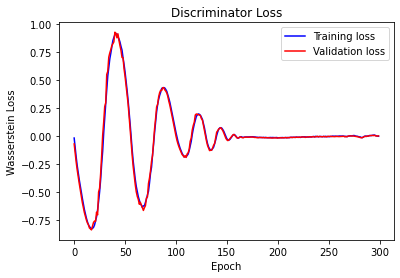

 31%|███       | 311/1000 [00:53<01:58,  5.83it/s]
Epoch 310:

Generator training loss: -0.12488780294855435
Discriminator training loss: 0.0020448867677866174

Generator validation loss: -0.16268915310502052
Discriminator validation loss: 0.006172616966068745
 32%|███▏      | 321/1000 [00:54<01:51,  6.08it/s]
Epoch 320:

Generator training loss: -0.18174254149198532
Discriminator training loss: -0.0035186418506782504

Generator validation loss: -0.19312912598252296
Discriminator validation loss: -0.006035734084434807
 33%|███▎      | 331/1000 [00:56<01:52,  5.97it/s]
Epoch 330:

Generator training loss: -0.5183224032322565
Discriminator training loss: 0.011220702257317802

Generator validation loss: -0.5529569536447525
Discriminator validation loss: -0.011649676831439137
 34%|███▍      | 341/1000 [00:58<01:51,  5.90it/s]
Epoch 340:

Generator training loss: -0.49682913968960446
Discriminator training loss: -0.3987800439198812

Generator validation loss: -0.517787255346775
Discriminato

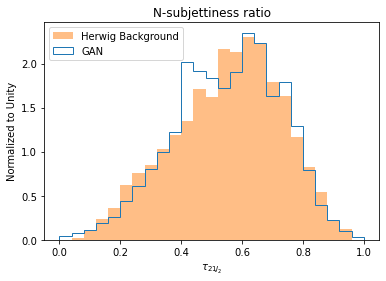

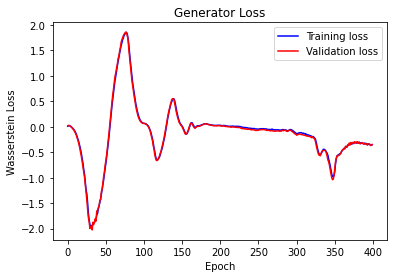

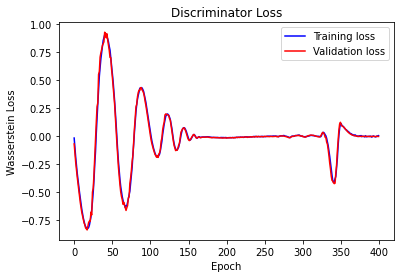

 41%|████      | 411/1000 [01:10<01:39,  5.89it/s]
Epoch 410:

Generator training loss: -0.36104292174180347
Discriminator training loss: -0.002836445396921287

Generator validation loss: -0.3513668179512024
Discriminator validation loss: -0.0019708852632902563
 42%|████▏     | 421/1000 [01:12<01:35,  6.04it/s]
Epoch 420:

Generator training loss: -0.3458811069528262
Discriminator training loss: 0.00503608575478817

Generator validation loss: -0.3598159849643707
Discriminator validation loss: 0.0005556310497922823
 43%|████▎     | 431/1000 [01:14<01:36,  5.88it/s]
Epoch 430:

Generator training loss: -0.307461753487587
Discriminator training loss: -0.004168132667352135

Generator validation loss: -0.2892461121082306
Discriminator validation loss: 0.00025626209389884025
 44%|████▍     | 441/1000 [01:15<01:31,  6.08it/s]
Epoch 440:

Generator training loss: -0.29697566976149875
Discriminator training loss: 0.0020654012914747

Generator validation loss: -0.2571740821003914
Discriminator v

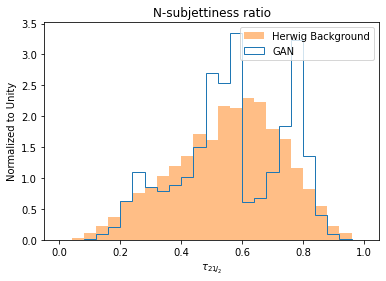

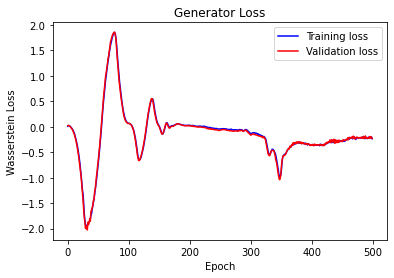

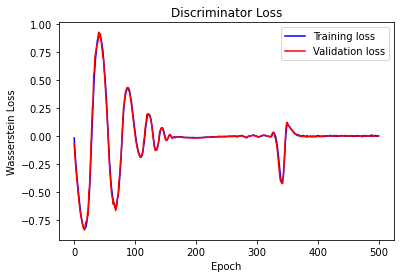

 51%|█████     | 511/1000 [01:28<01:27,  5.56it/s]
Epoch 510:

Generator training loss: -0.1825472079217434
Discriminator training loss: -0.0012532469118013978

Generator validation loss: -0.18829293549060822
Discriminator validation loss: -0.0004195745423203334
 52%|█████▏    | 521/1000 [01:30<01:20,  5.96it/s]
Epoch 520:

Generator training loss: -0.17361894622445107
Discriminator training loss: -0.002004374528769404

Generator validation loss: -0.18780208379030228
Discriminator validation loss: -0.0003946583019569516
 53%|█████▎    | 531/1000 [01:31<01:20,  5.86it/s]
Epoch 530:

Generator training loss: -0.19251393775145212
Discriminator training loss: 0.0037323451639773944

Generator validation loss: -0.1905304454267025
Discriminator validation loss: -0.001138733365223743
 54%|█████▍    | 541/1000 [01:33<01:20,  5.74it/s]
Epoch 540:

Generator training loss: -0.19965042546391487
Discriminator training loss: -0.003637749903524915

Generator validation loss: -0.1969805248081684
Discr

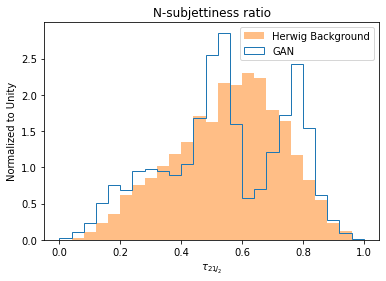

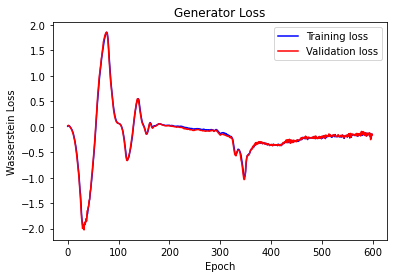

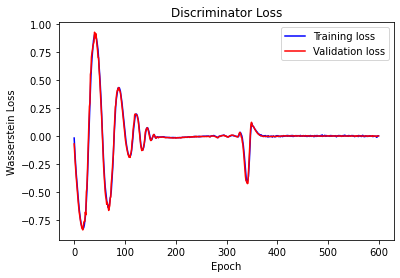

 61%|██████    | 610/1000 [01:46<01:10,  5.54it/s]
Epoch 610:

Generator training loss: -0.14658368503053984
Discriminator training loss: -0.004743545576153944

Generator validation loss: -0.10084731504321098
Discriminator validation loss: -0.0006392776995198801
 62%|██████▏   | 620/1000 [01:48<01:10,  5.36it/s]
Epoch 620:

Generator training loss: -0.14522987604141235
Discriminator training loss: -0.0016143710662921268

Generator validation loss: -0.15741141512989998
Discriminator validation loss: 0.0006397384859155864
 63%|██████▎   | 630/1000 [01:50<01:09,  5.33it/s]
Epoch 630:

Generator training loss: -0.18634945278366408
Discriminator training loss: 0.006108686568525931

Generator validation loss: -0.13836853578686714
Discriminator validation loss: -0.0004841262998525053
 64%|██████▍   | 641/1000 [01:52<00:59,  5.99it/s]
Epoch 640:

Generator training loss: -0.1569976471364498
Discriminator training loss: -0.0016690522742768127

Generator validation loss: -0.15379653871059418
Dis

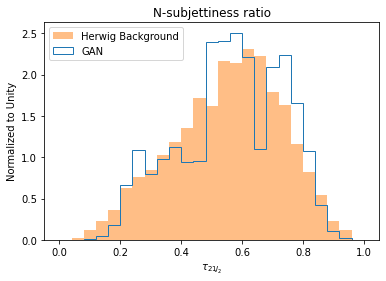

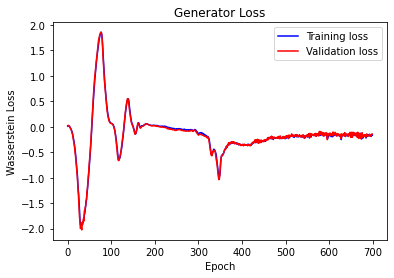

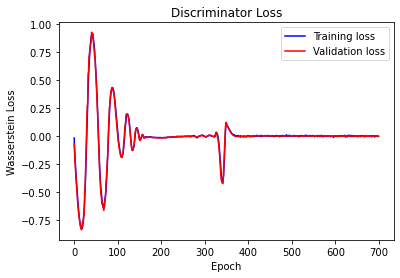

 71%|███████   | 711/1000 [02:05<00:51,  5.58it/s]
Epoch 710:

Generator training loss: -0.1725300041337808
Discriminator training loss: -0.0006561757608627279

Generator validation loss: -0.19661985710263252
Discriminator validation loss: -0.0011741814960259944
 72%|███████▏  | 721/1000 [02:06<00:46,  6.00it/s]
Epoch 720:

Generator training loss: -0.1567829300959905
Discriminator training loss: 0.00011370977542052668

Generator validation loss: -0.14849228411912918
Discriminator validation loss: 0.00047072122106328607
 73%|███████▎  | 731/1000 [02:08<00:45,  5.86it/s]
Epoch 730:

Generator training loss: -0.18788226569692293
Discriminator training loss: 0.004414337000343949

Generator validation loss: -0.17527573555707932
Discriminator validation loss: -0.001024571669404395
 74%|███████▍  | 741/1000 [02:10<00:43,  6.02it/s]
Epoch 740:

Generator training loss: -0.1631664608915647
Discriminator training loss: -0.0015693966881372035

Generator validation loss: -0.18087607622146606
Disc

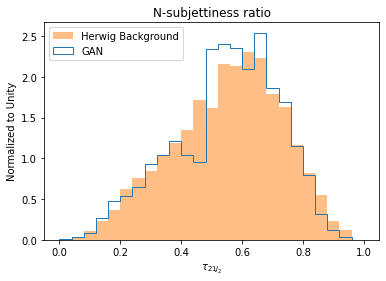

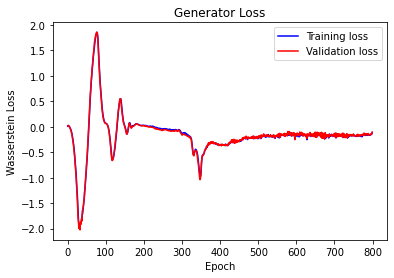

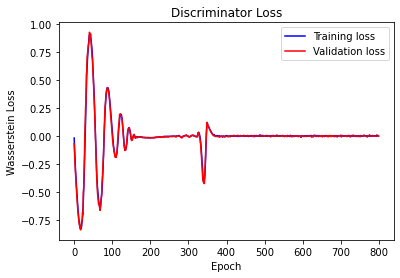

 81%|████████  | 811/1000 [02:23<00:32,  5.77it/s]
Epoch 810:

Generator training loss: -0.10589707208176453
Discriminator training loss: 0.0014272373790542284

Generator validation loss: -0.15747414529323578
Discriminator validation loss: -0.0014790674613323063
 82%|████████▏ | 821/1000 [02:24<00:30,  5.78it/s]
Epoch 820:

Generator training loss: -0.14399784803390503
Discriminator training loss: -0.0017578277581681806

Generator validation loss: -0.12171105295419693
Discriminator validation loss: -0.001473053707741201
 83%|████████▎ | 831/1000 [02:26<00:27,  6.13it/s]
Epoch 830:

Generator training loss: -0.14698864022890726
Discriminator training loss: -0.0052438366925343875

Generator validation loss: -0.11889756098389626
Discriminator validation loss: -0.0020058625959791243
 84%|████████▍ | 841/1000 [02:28<00:26,  6.08it/s]
Epoch 840:

Generator training loss: -0.16018787026405334
Discriminator training loss: 0.0022551223868504167

Generator validation loss: -0.1434040181338787
Di

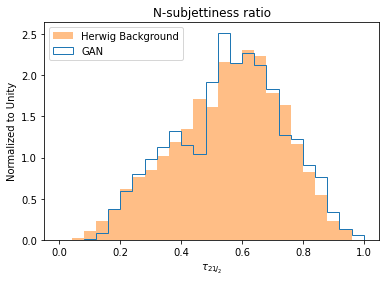

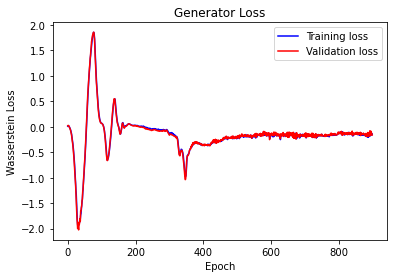

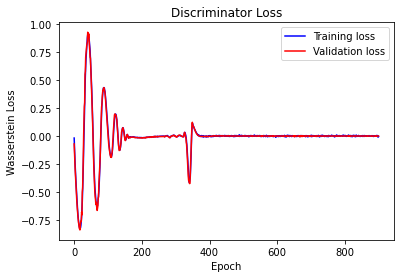

 91%|█████████ | 911/1000 [02:42<00:16,  5.31it/s]
Epoch 910:

Generator training loss: -0.1731654666364193
Discriminator training loss: -0.0009042112564202398

Generator validation loss: -0.12017624080181122
Discriminator validation loss: -0.0033758750068955123
 92%|█████████▏| 920/1000 [02:43<00:14,  5.60it/s]
Epoch 920:

Generator training loss: -0.11400254381199677
Discriminator training loss: 0.0016997196750404935

Generator validation loss: -0.1179384533315897
Discriminator validation loss: -0.00039775478580850177
 93%|█████████▎| 931/1000 [02:45<00:12,  5.50it/s]
Epoch 930:

Generator training loss: -0.12990495872994265
Discriminator training loss: -0.0010748147033154964

Generator validation loss: -0.162698395550251
Discriminator validation loss: -0.00037273444468155503
 94%|█████████▍| 941/1000 [02:47<00:10,  5.56it/s]
Epoch 940:

Generator training loss: -0.1344925326605638
Discriminator training loss: -0.0001945100724697113

Generator validation loss: -0.13856583088636398
Di

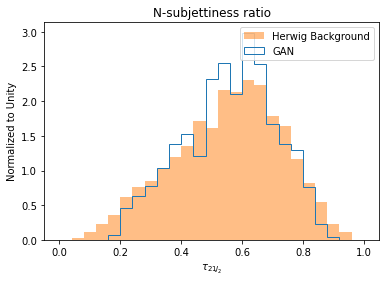

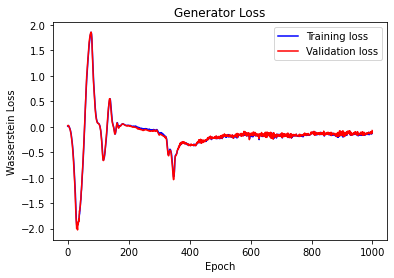

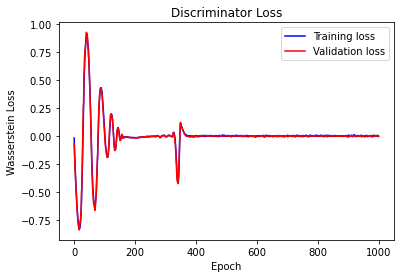

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


In [27]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)